# Receiver Prediction

The aim is to predict the best possible receiver based on the player position configuration.

We achieve this by following:
1. Construct a graph representing the players in the image
2. Use this graph to train a Graph Neural Network to perform node classification

# Graph Construction:

The method employs a combination of techniques, including perspective transformation, clustering, and distance matrix calculations. The perspective transformation is used to derive the true ground X and Y coordinates, while clustering is used to identify the teams in the image. The distance matrix is then employed to determine ball possession. These values are then used to construct a directed graph similar to the one below, that is fed to the Graph Neural Network.

- $L$: denotes the left team
- $R$: denotes the right team
- $bp$: denotes ball possession
- $br$: denotes ball receiver

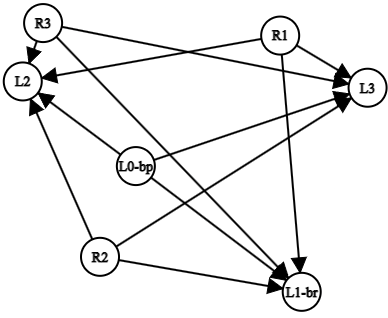


Node Features:
- normalised gnd_x
- normalised gnd_y
- one hot encoded team values
- bp(ball_possession) bool value

Edge Features:

The graph is constructed with directed edges such that only nodes of team members of the ball_possesor are updated via the Message Passing Function in GNNs.

Edge weights:
- the edges are initialised with weights inversely proportional to the distance, as more weightage would be given to nearer players. 
- only for GATs (as negative weights are allowed), the weights between opposite team memebers is made negative while same team members remains the same

In [1]:
import importlib
import gnn.utils as utils
importlib.reload(utils)
from gnn.utils import *
import gnn.gnn_datagen as ggen 
from gnn.gnn_models import *
import cv2
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw

In [2]:
def accuracy(model,val_loader,idx=-1,thr=0.2):
    output_list=[]
    val_list=[]
    accv=0
    for val_data in val_loader:
        output = model(val_data)
        label_val = val_data.y
        val_lbl=torch.argmax(label_val.long())
        max_idx=torch.argmax(output)
        lbl_idx=torch.argmax(val_data.y)
        accv+=(1.0 if max_idx==lbl_idx else 0.0)
        output_list.append(output)
        val_list.append(val_data)
    i=len(val_loader.dataset)       

    print("Number of Correct Predictions= {:.0f}/{}, Accuracy={:.3f}".format(accv,i,accv/i))
    image=create_image_from_tensor(val_list[idx],output_list[idx],gnd_image =fb_gnd,threshold=thr)
    return image

In [3]:
file_path = "processed/data.pt"
if os.path.exists(file_path):
    os.remove(file_path)
importlib.reload(ggen)
graph_list=ggen.csv2data(path="gnn/Data/gnn_nval.csv",csv_df="csv",label_smoothing=0.0,graphfunc=2,undirected=False,negEdge=True)
dataset=MyDataset("",graph_list)
val_loader =DataLoader(dataset, batch_size=1)

Processed 206 objects and 1 skipped


Processing...
Done!


# Example Dataset 

The below image shows an example of the graphed dataset, to make it clear only bp-br edge is being displayed.
The circle with outer halo is Ball Possesion and the other point on the line is the Ball Receiver. And the value of edge=the predicted score of the pass and if the true_label was 1 then colour of text is green otherwise pink. 


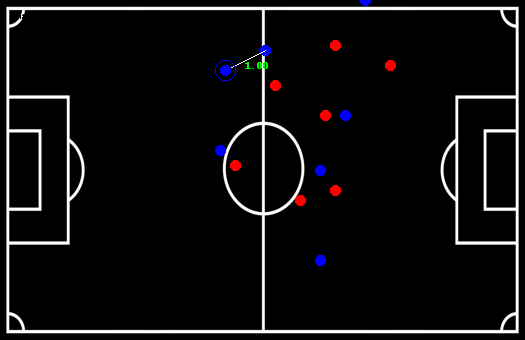

In [26]:
fb_gnd=cv2.imread("gnn/fb_gnd_bw.jpg")
num=195
label=graph_list[num].y[:,None]
create_image_from_tensor(graph_list[num],label,gnd_image =fb_gnd)

# Training Methodology

#### General Model Architecture:
1. Linear Layer embeds the 5 node features into N dimensions
2. Followd by K Layers of GNN Message Passing Layers
3. Softmax applied across all nodes
4. BCE loss => as value ranges between 0 and 1 (reciever or not)
5. Weighted BCE loss to counter class imbalance of Reciever nodes and non Reciever Nodes

#### Training:

1. We hand generated ~400 examples (created using a graph tool found in this repo)
2. We added noise to each example to increase the dataset to ~2000 samples
3. This dataset was used to pretrain this architecture of GATV2 
4. From our own training set ~1000 samples => we added noise to increase to ~3000 samples
5. The pretrained model was fine tuned on our dataset and saved.
6. The following are the loaded weights from pretraining + new training 

# GAT-V2 
### Graph Attention Networks Version 2

In [5]:
graph_list=ggen.csv2data(path="gnn/Data/gnn_nval.csv",csv_df="csv",negEdge=True)
dataset=MyDataset("",graph_list)
val_loader =DataLoader(dataset, batch_size=1)

gat2 = GAT2(hidden_channels= [32,32,32],heads=5,dropout=0)
PATH = './gnn/model_weights/best_model_GATv2_pre_ntrain_5.pt'
state = torch.load(PATH)
gat2.load_state_dict(state['state_dict'])


Processed 206 objects and 1 skipped


Processing...
Done!


<All keys matched successfully>

Number of Correct Predictions= 177/206, Accuracy=0.859


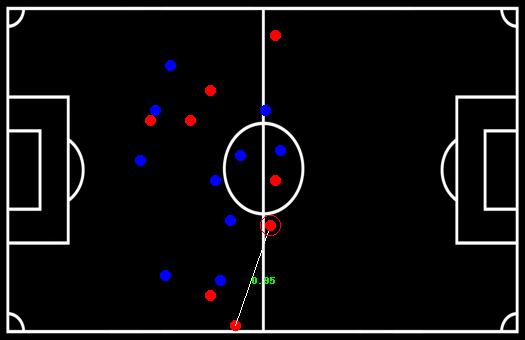

In [6]:
accuracy(gat2,val_loader,115)

# GCN 
### Graph Convolution Network

In [7]:
graph_list=ggen.csv2data(path="gnn/Data/gnn_nval.csv",csv_df="csv",negEdge=False)
dataset=MyDataset("",graph_list)
val_loader =DataLoader(dataset, batch_size=1)


model = GCN(hidden_channels= [16,16,16])
PATH = './gnn/model_weights/best_model_GCNConv_pre_train.pt'
state = torch.load(PATH)
model.load_state_dict(state['state_dict'])

Processed 206 objects and 1 skipped


Processing...
Done!


<All keys matched successfully>

Number of Correct Predictions= 83/206, Accuracy=0.403


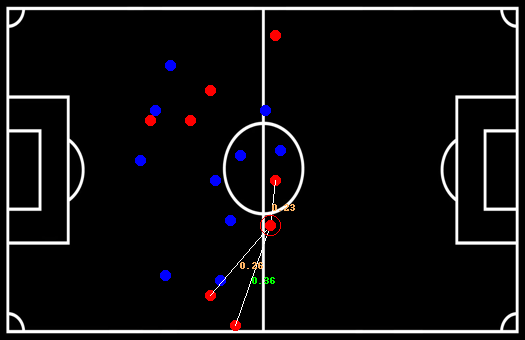

In [8]:
accuracy(model,val_loader,115)

# GAT
### Graph Attention Networks

In [29]:
graph_list=ggen.csv2data(path="gnn/Data/gnn_nval.csv",csv_df="csv",negEdge=False)
dataset=MyDataset("",graph_list)
val_loader =DataLoader(dataset, batch_size=1)


gat = GAT(hidden_channels= [32,32,32],heads=5,dropout=0)
PATH = './gnn/model_weights/best_model_GATConvBest_train.pt'#_pre_ntrain_5.pt
state = torch.load(PATH)
gat.load_state_dict(state['state_dict'])

Processed 206 objects and 1 skipped


Processing...
Done!


<All keys matched successfully>

Number of Correct Predictions= 65/206, Accuracy=0.316


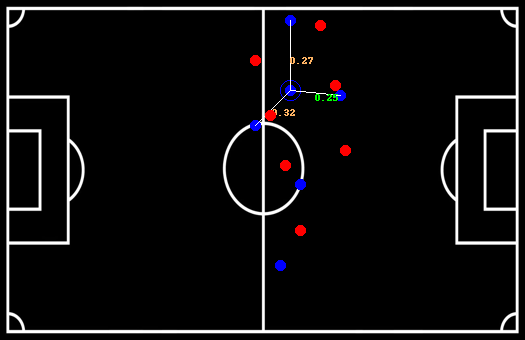

In [30]:
accuracy(gat,val_loader,105)